In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class CombinatorialPathwayDataset(Dataset):

  def __init__(self, csv_file):
    self.data =  pd.read_csv(csv_file).drop('Unnamed: 0', axis=1)
    self.columns = self.data.columns.values
    self.labels = self.data.values
    self.features = self.data.drop('Product_I', axis=1).values
    self.target = self.data['Product_I'].values
    self.training_data = self.data.sample(frac=0.6, random_state=25)
    self.testing_data = self.data.drop(self.training_data.index)
    self.training_labels = self.data.sample(frac=0.6, random_state=25)
    self.testing_labels = self.data.drop(self.training_labels.index)


  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    training_data = self.training_data.to_numpy()
    training_labels = self.training_labels.to_numpy()

    # Convert features and targets to PyTorch tensor
    features_tensor = torch.tensor(training_data, dtype=torch.float32)
    target_tensor = torch.tensor(training_labels, dtype=torch.float32)

    return features_tensor, target_tensor


# Replace 'your_data.csv' with the actual path to your CSV file
csv_file_path = 'Continuous_Pathway_I_VAE_dataset1.csv'

# Create an instance of your custom CSV dataset
custom_csv_dataset = CombinatorialPathwayDataset(csv_file_path)

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes):
        super().__init__()
        # Set the number of hidden units
        self.num_hidden = 10
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 15),  # input size: input_dim, output size: 15
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(15, self.num_hidden),  # input size: 15, output size: num_hidden
            nn.ReLU(),  # apply the ReLU activation function
        )

        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 15),  # input size: num_hidden, output size: 15
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(15, output_dim),  # input size: 15, output size: output_dim
        )
        # Add a linear layer for the class label
        self.label_projector = nn.Sequential(
            nn.Linear(num_classes, self.num_hidden),
            nn.ReLU(),
        )

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std

    def condition_on_label(self, z, y):
        projected_label = self.label_projector(y)
        return z + projected_label

    def forward(self, x, y):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(self.condition_on_label(z, y))
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(self.condition_on_label(z, y))
        # Return the generated samples
        return samples

In [ ]:
def train_cvae(model, X_train, beta, learning_rate, weight_decay, num_epochs, batch_size):

    mse_values = []
    kld_values = []
    loss_arr = []

    # Create the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Define the loss function
    criterion = nn.MSELoss(reduction="sum")

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Create a DataLoader to handle batching of the training data
    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, shuffle=True
    )

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        n = len(X_train)
        for batch_idx, data in enumerate(train_loader):
            n = n - 1
            # Get a batch of training data and move it to the device
            #print(data)
            x, y = data
            # Move tensors to the specified device (GPU)
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            encoded, decoded, mu, log_var = model(x, y)

            # Compute the loss and perform backpropagation
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            MSE = criterion(decoded, x)
            loss = ((1 - beta) * MSE) + (beta * KLD)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * x.size(0)

        mse_values.append(MSE.cpu().detach())
        kld_values.append(KLD.cpu().detach())
        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        loss_arr.append(epoch_loss)
        if epoch % 10 == 0:
          print(
              "Epoch {}/{}: loss={:.4f} kld={:.4f}".format(epoch + 1, num_epochs, epoch_loss, KLD.cpu().detach())
          )

    # Return the trained model and the data
    return model, mse_values, kld_values, loss_arr

In [ ]:
input_dim = 20
output_dim = 20
num_classes = 20
beta = 0.75
learning_rate = 1e-4
weight_decay = 1e-3
num_epochs = 1000
batch_size = 100

In [ ]:
print(device)
num_samples = 2000
labels = torch.tensor(custom_csv_dataset.testing_labels.to_numpy(), dtype=torch.float32).to(device)

cvae = ConditionalVAE(input_dim, output_dim, num_classes)
cvae, mse, kld, loss_arr = train_cvae(cvae, custom_csv_dataset, beta, learning_rate, weight_decay, num_epochs, batch_size)
generated_samples = cvae.sample(num_samples, labels).cpu().detach()

cuda
Epoch 1/1000: loss=492191.5162 kld=29878.4492
Epoch 11/1000: loss=74032.0696 kld=976.1078
Epoch 21/1000: loss=61999.4368 kld=371.4462
Epoch 31/1000: loss=56500.6702 kld=245.3963
Epoch 41/1000: loss=52613.3622 kld=202.4101
Epoch 51/1000: loss=48482.0143 kld=240.4013
Epoch 61/1000: loss=44638.7818 kld=243.5976
Epoch 71/1000: loss=41213.9982 kld=221.1521
Epoch 81/1000: loss=38297.9639 kld=179.9229
Epoch 91/1000: loss=35605.7901 kld=153.8008
Epoch 101/1000: loss=33166.6062 kld=132.9787
Epoch 111/1000: loss=30886.4004 kld=120.3622
Epoch 121/1000: loss=28569.5384 kld=110.3683
Epoch 131/1000: loss=26510.0078 kld=97.5494
Epoch 141/1000: loss=24779.4368 kld=84.7085
Epoch 151/1000: loss=23320.0485 kld=72.2197
Epoch 161/1000: loss=22085.0034 kld=61.5870
Epoch 171/1000: loss=21026.7774 kld=51.5407
Epoch 181/1000: loss=20118.7856 kld=43.3997
Epoch 191/1000: loss=19332.5067 kld=36.0059
Epoch 201/1000: loss=18640.2376 kld=30.1314
Epoch 211/1000: loss=18036.2247 kld=25.4551
Epoch 221/1000: loss=1

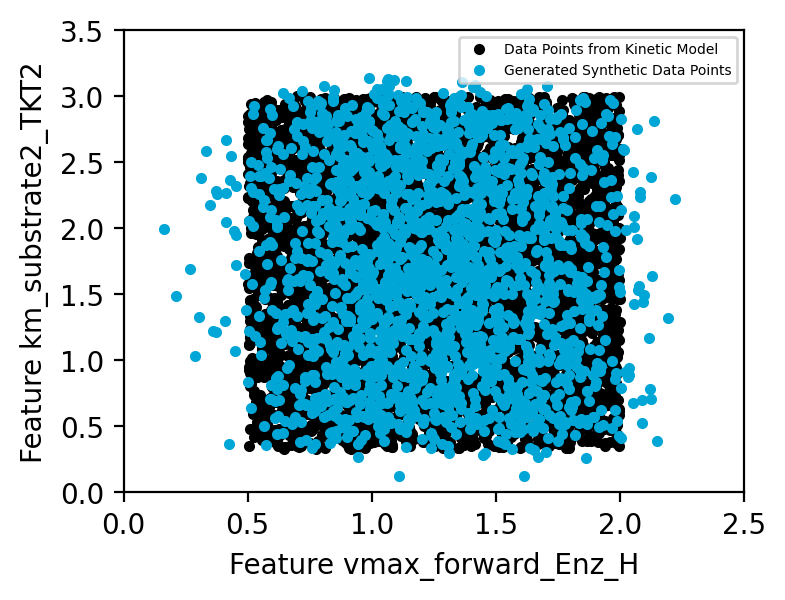

In [ ]:
feature_1 = 7
feature_2 = 13
plt.figure(figsize=(4,3))
plt.plot(custom_csv_dataset.labels[:, feature_1], custom_csv_dataset.labels[:, feature_2], ".", color='black')
plt.plot(generated_samples[:, feature_1], generated_samples[:, feature_2], ".", color='#00a6d6')
plt.legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="5", loc ="upper right")
plt.xlabel(f"Feature {custom_csv_dataset.data.columns[feature_1]}")
plt.ylabel(f"Feature {custom_csv_dataset.data.columns[feature_2]}")
plt.axis([0, 2.5, 0, 3.5])
plt.show()

In [ ]:
pca_real = PCA(n_components=10, random_state=42)
real_result = pca_real.fit_transform(custom_csv_dataset.labels)
pca_synthetic = PCA(n_components=10, random_state=42)
synthetic_result = pca_synthetic.fit_transform(generated_samples)

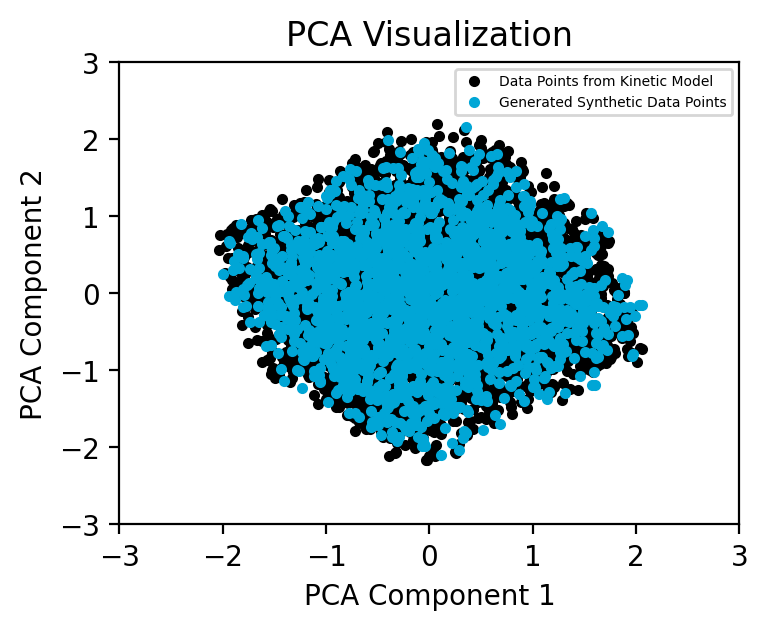

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(real_result[:,0], real_result[:, 1],".", color='black')
plt.plot(synthetic_result[:,0], synthetic_result[:, 1],".", color='#00a6d6')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization')
plt.legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="5", loc ="upper right")
plt.axis([-3, 3, -3, 3])
plt.show()

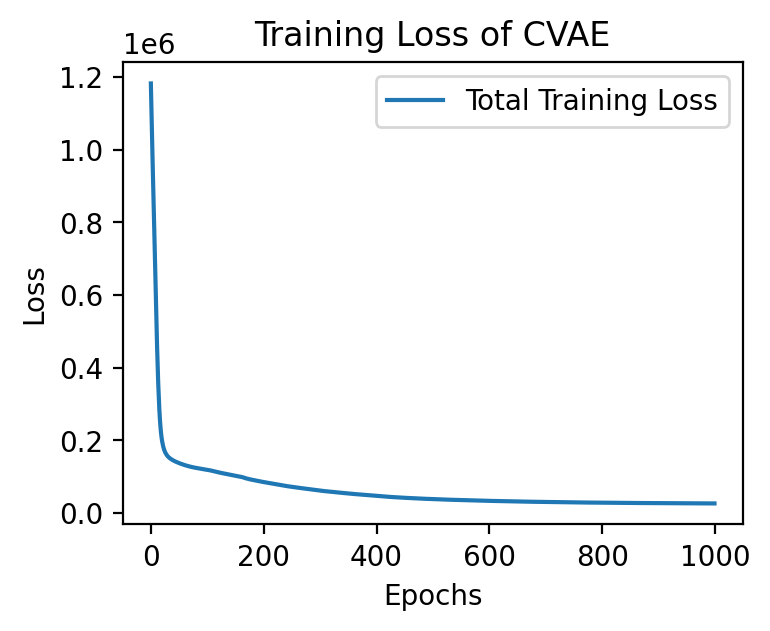

In [ ]:
# Assuming loss_arr contains the stored loss values from training
plt.figure(figsize=(4, 3))
plt.plot(loss_arr, label='Total Training Loss')
plt.title('Training Loss of CVAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

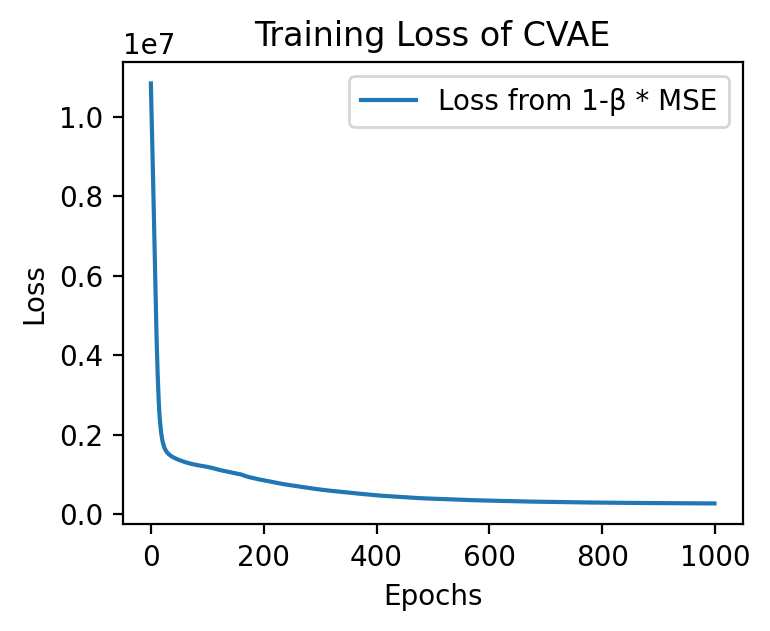

In [ ]:
# Assuming mse contains the stored loss values from training
plt.figure(figsize=(4, 3))
plt.plot(mse, label='Loss from 1-β * MSE')
plt.title('Training Loss of CVAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

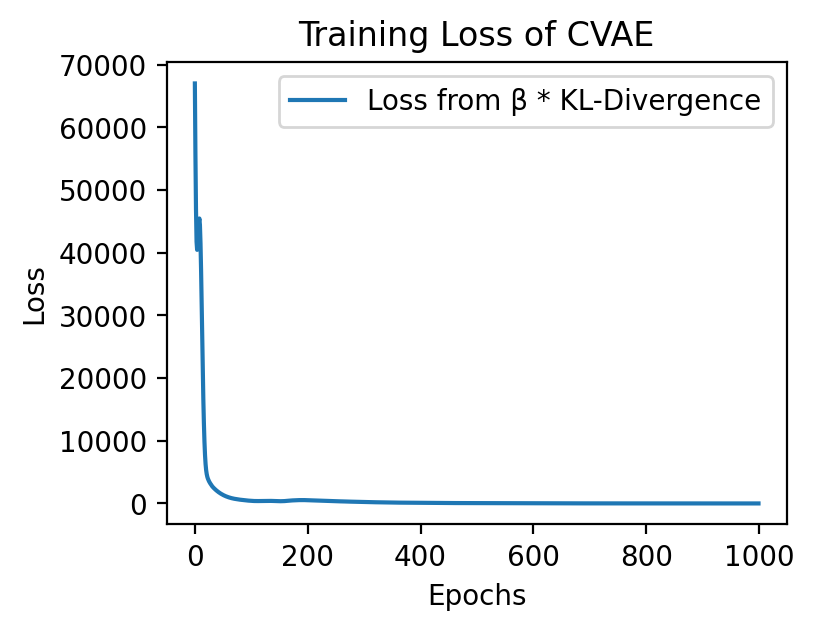

tensor(3.4603)


In [ ]:
# Assuming kld contains the stored loss values from training
plt.figure(figsize=(4, 3))
plt.plot(kld, label='Loss from β * KL-Divergence')
plt.title('Training Loss of CVAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(kld[len(kld) - 1])

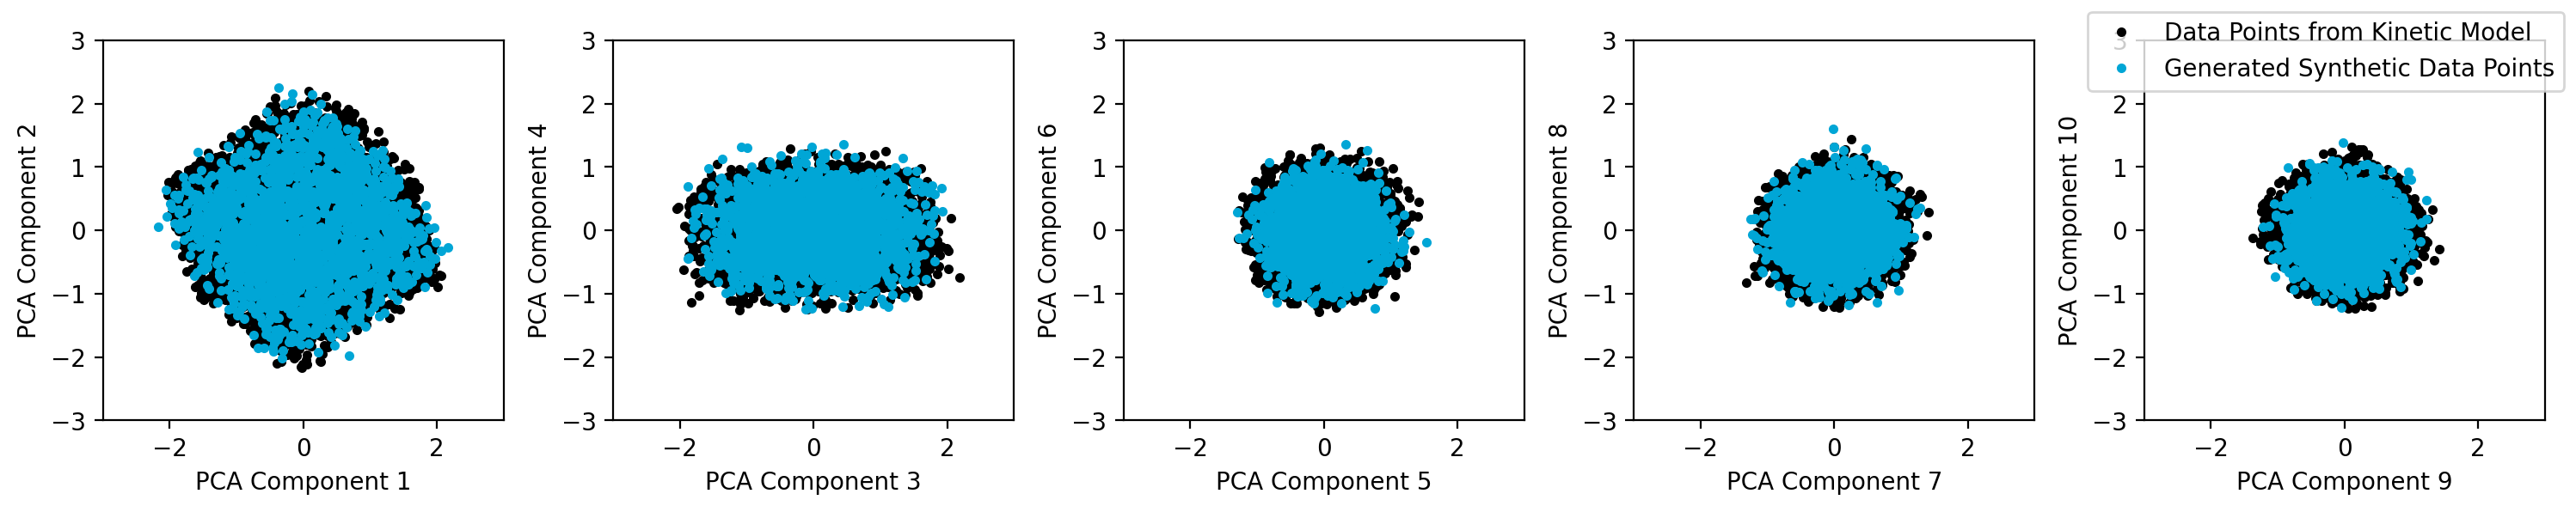

In [ ]:
kinetic_samples = pd.read_csv("Continuous_Pathway_I_VAE_dataset1.csv").drop('Unnamed: 0', axis=1)
generated_data = pd.read_csv("data_ld5_beta0.75_lr1e-4_wd1e-3_ne1000_batch_100.csv").drop('Unnamed: 0', axis=1)

pca_real = PCA(n_components=10, random_state=25)
real_result = pca_real.fit_transform(kinetic_samples)

pca_synthetic = PCA(n_components=10, random_state=25)
generated_samples = generated_data.sample(n=2000, random_state=25)
synthetic_result = pca_synthetic.fit_transform(generated_samples)

fig, axes = plt.subplots(ncols=5, figsize=(15,3))

for j in range(0, 10, 2):
    index = j
    index2 = j + 1
    arr_idx = j//2
    axes[arr_idx].plot(real_result[:, index], real_result[:, index2],".", color='black')
    axes[arr_idx].plot(synthetic_result[:, index], synthetic_result[:, index2],".", color='#00a6d6')
    axes[arr_idx].set_xlabel(f'PCA Component {index + 1}')
    axes[arr_idx].set_ylabel(f'PCA Component {index2 + 1}')
    axes[arr_idx].axis([-3, 3, -3, 3])
#             axes[i, j].legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="15", loc ="upper right")

fig.legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="10", loc ="upper right")
fig.set_label('PCA Visualization')
plt.tight_layout(w_pad=1.0)
plt.show()

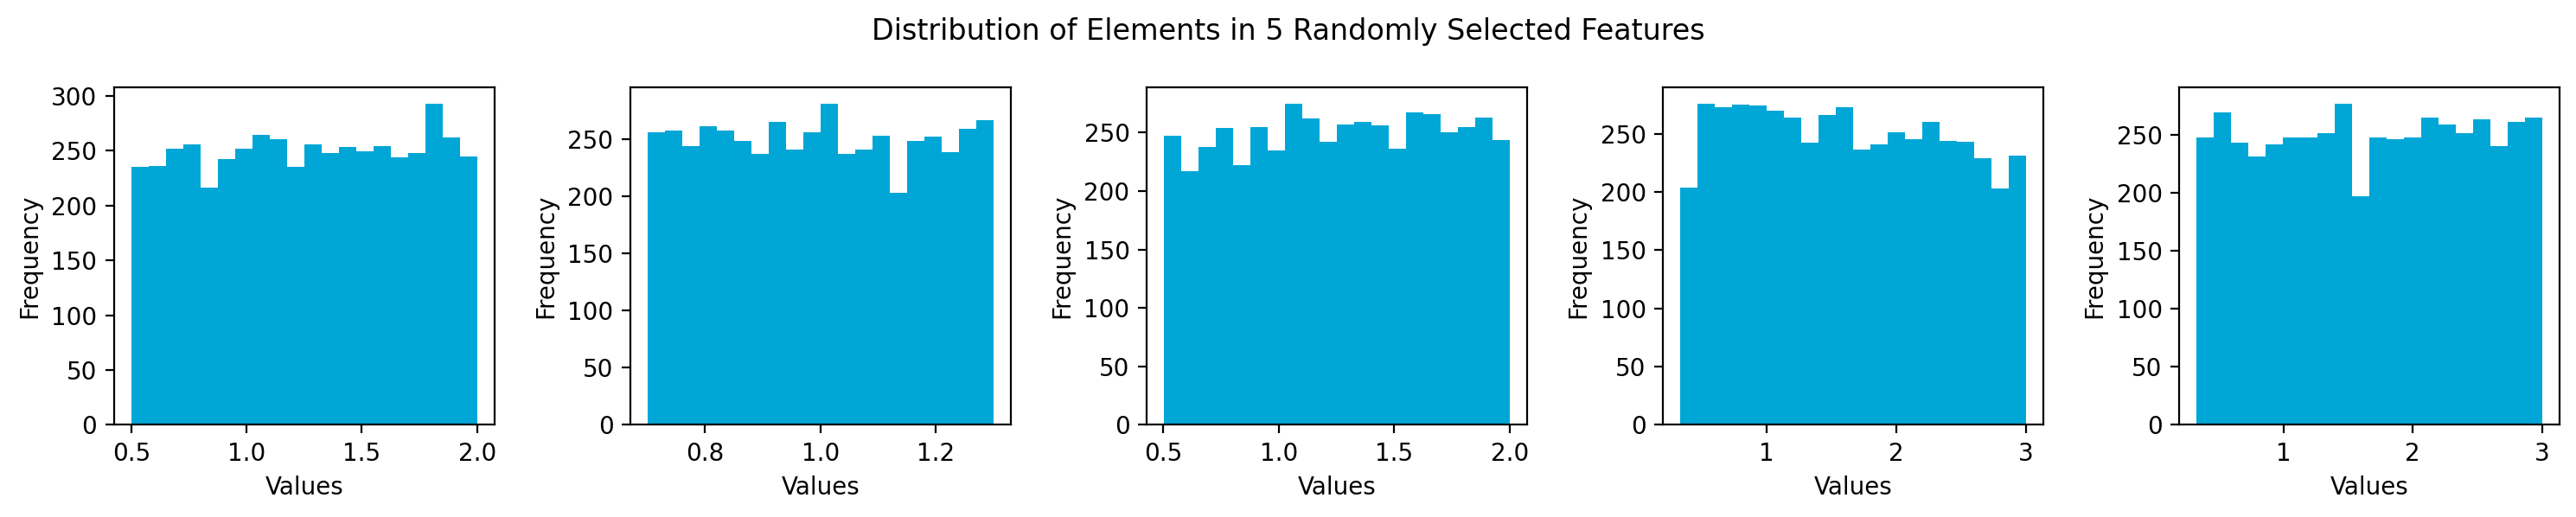

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(15,3))

for j in range(0, 10, 2):
    index = j
    index2 = j + 1
    arr_idx = j//2
    # Extract a column with all rows from the DataFrame
    feature_id = np.random.randint(0, 19)
    first_column_r =  custom_csv_dataset.data.iloc[:, feature_id]
    axes[arr_idx].hist(first_column_r, bins=20, alpha=1.0, color='#00a6d6')
    axes[arr_idx].set_xlabel('Values')
    axes[arr_idx].set_ylabel('Frequency')
    # axes[arr_idx].axis([-3, 3, -3, 3])
#             axes[i, j].legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="15", loc ="upper right")

fig.suptitle('Distribution of Elements in 5 Randomly Selected Features')
plt.tight_layout(w_pad=1.5)
plt.show()

In [ ]:
# Save the data to a csv file with same column names as original
final_samples = generated_samples
print(final_samples)
df = pd.DataFrame(final_samples)
df.columns = custom_csv_dataset.columns
df.to_csv("data_ld5_beta0.9_lr1e-4_wd1e-3_ne1000_batch_50_testing.csv")

      vmax_forward_Enz_A  vmax_forward_Enz_B  vmax_forward_Enz_C  \
1050            0.926470            0.984151            1.131719   
1748            1.400344            1.497951            1.676821   
1685            1.673049            1.306001            1.198811   
365             1.684735            1.734933            1.670853   
1445            1.263299            1.436411            1.124496   
...                  ...                 ...                 ...   
1341            1.195948            1.037424            0.866735   
143             0.677965            1.092196            1.093240   
474             1.343537            0.773242            1.525162   
318             0.398206            1.101540            1.137182   
1156            1.806701            1.758681            1.455327   

      vmax_forward_Enz_D  vmax_forward_Enz_E  vmax_forward_Enz_F  \
1050            1.271994            1.134243            1.351022   
1748            1.207065            1.259650   